In [1]:
from gpu_helper import enable_gpu

enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [2]:
%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [16]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
)
import cv2
from utils import *
from model import yolo_model

In [4]:
anchors = (
    np.array(
        [(10, 14), (23, 27), (37, 58), (81, 82), (135, 169), (344, 319)], np.float32
    )
    / 416
)
anchor_masks = np.array([[3, 4, 5], [0, 1, 2]])

In [5]:
IMAGE_FEATURE_MAP = {
    "image/encoded": tf.io.FixedLenFeature([], tf.string),
    "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
    "image/object/class/text": tf.io.VarLenFeature(tf.string),
}

In [6]:
def parse_record(record, class_table, size):
    x = tf.io.parse_single_example(record, IMAGE_FEATURE_MAP)

    x_train = tf.image.decode_jpeg(x["image/encoded"], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    class_text = tf.sparse.to_dense(x["image/object/class/text"], default_value="")
    labels = tf.cast(class_table.lookup(class_text), tf.float32)

    y_train = tf.stack(
        [
            tf.sparse.to_dense(x["image/object/bbox/xmin"]),
            tf.sparse.to_dense(x["image/object/bbox/ymin"]),
            tf.sparse.to_dense(x["image/object/bbox/xmax"]),
            tf.sparse.to_dense(x["image/object/bbox/ymax"]),
            labels,
        ],
        axis=1,
    )

    max_boxes = 10  # change this
    paddings = [[0, max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train

In [7]:
def load_dataset(file_pattern, class_file, size):
    LN = -1

    class_table = tf.lookup.StaticHashTable(
        tf.lookup.TextFileInitializer(
            class_file, tf.string, 0, tf.int64, LN, delimiter="\n"
        ),
        -1,
    )

    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    return dataset.map(lambda record: parse_record(record, class_table, size))

In [8]:
ds = load_dataset("data/images/military_train.tfrecord", "data/classes.txt", 416)

In [9]:
ds = ds.shuffle(512)

In [10]:
class_names = [c.strip() for c in open("data/classes.txt").readlines()]

In [11]:
def draw_bbx(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(
            img,
            "{} {:.4f}".format(class_names[int(classes[i])], objectness[i]),
            x1y1,
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            1,
            (0, 0, 255),
            2,
        )

    return img

labels:
	BMP-97, 1, [0.06875   0.267101  0.8541667 0.8273616]


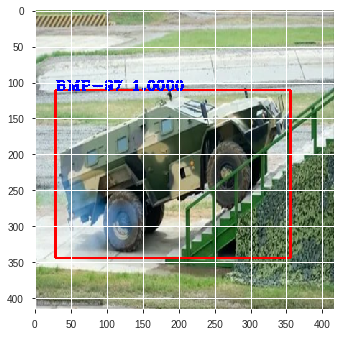

In [15]:
for image, labels in ds.take(1):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    print("labels:")
    for i in range(nums[0]):
        print(
            "\t{}, {}, {}".format(
                class_names[int(classes[0][i])],
                np.array(scores[0][i]),
                np.array(boxes[0][i]),
            )
        )

        img = draw_bbx(image.numpy(), (boxes, scores, classes, nums), class_names)
        plt.imshow(img.astype(int))

In [14]:
def yolo_boxes(pred, anchors, n_classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, n_classes), axis=-1
    )

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

In [15]:
def yolo_nms(outputs, anchors, masks, classes):
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=10,
        max_total_size=10,
        iou_threshold=0.5,
        score_threshold=0.5,
    )

    return boxes, scores, classes, valid_detections

In [16]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)

        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [17]:
def create_conv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = "same"
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = "valid"

    x = Conv2D(
        filters=filters,
        kernel_size=size,
        strides=strides,
        padding=padding,
        use_bias=not batch_norm,
        kernel_regularizer=l2(0.0005),
    )(x)

    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)

    return x

In [18]:
def create_darknet(name):
    x = inputs = Input([None, None, 3])
    x = create_conv(x, 16, 3)
    x = MaxPool2D(2, 2, "same")(x)
    x = create_conv(x, 32, 3)
    x = MaxPool2D(2, 2, "same")(x)
    x = create_conv(x, 64, 3)
    x = MaxPool2D(2, 2, "same")(x)
    x = create_conv(x, 128, 3)
    x = MaxPool2D(2, 2, "same")(x)
    x = x_8 = create_conv(x, 256, 3)  # skip connection
    x = MaxPool2D(2, 2, "same")(x)
    x = create_conv(x, 512, 3)
    x = MaxPool2D(2, 1, "same")(x)
    x = create_conv(x, 1024, 3)

    return Model(inputs, (x_8, x), name=name)

In [19]:
def create_yolo_conv(filters, name):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = create_conv(x, filters=filters, size=1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
            x = create_conv(x=x, filters=filters, size=1)

        return Model(inputs, x, name=name)(x_in)

    return yolo_conv

In [20]:
def create_yolo_out(filters, anchors, n_classes, name=None):
    def yolo_out(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = create_conv(x=x, filters=filters * 2, size=3)
        x = create_conv(
            x=x, filters=anchors * (n_classes + 5), size=1, batch_norm=False
        )
        x = Lambda(
            lambda x: tf.reshape(
                x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, n_classes + 5)
            )
        )(x)

        return Model(inputs, x, name=name)(x_in)

    return yolo_out

In [21]:
def yolo_model(size, anchors, masks, n_classes, training=False):
    x = inputs = Input([size, size, 3], name="input")

    x_8, x = create_darknet(name="yolo_darknet")(x)

    x = create_yolo_conv(256, name="yolo_conv_0")(x)
    out_0 = create_yolo_out(256, len(masks[0]), n_classes, name="yolo_out_0")(x)

    x = create_yolo_conv(128, name="yolo_conv_1")((x, x_8))
    out_1 = create_yolo_out(128, len(masks[1]), n_classes, name="yolo_out_1")(x)

    if training:
        return Model(inputs, (out_0, out_1), name="yolo3")

    boxes_0 = Lambda(
        lambda x: yolo_boxes(x, anchors[masks[0]], n_classes), name="yolo_boxes_0"
    )(out_0)
    boxes_1 = Lambda(
        lambda x: yolo_boxes(x, anchors[masks[1]], n_classes), name="yolo_boxes_1"
    )(out_1)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, n_classes), name="yolo_nms")(
        (boxes_0[:3], boxes_1[:3])
    )

    return Model(inputs, outputs, name="yolo")

In [22]:
# consider removing this
def transfrom_img(image, size):
    image = tf.image.resize(image, (size, size))
    image = image / 255
    return image

In [63]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros((N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1 / grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]]
                )
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]]
                )
                idx += 1

    # tf.print(indexes.stack())
    # tf.print(updates.stack())

    return tf.tensor_scatter_nd_update(y_true_out, indexes.stack(), updates.stack())

In [60]:
def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * tf.minimum(
        box_wh[..., 1], anchors[..., 1]
    )
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)

In [70]:
IMG_SIZE = 416

In [93]:
train_ds = ds.batch(6)
train_ds = train_ds.map(
    lambda x, y: (
        transfrom_img(x, IMG_SIZE),
        transform_targets(y, anchors, anchor_masks, IMG_SIZE),
    )
)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [94]:
val_ds = load_dataset("data/images/military_val.tfrecord", "data/classes.txt", IMG_SIZE)

In [95]:
val_ds = val_ds.batch(6)
val_ds = val_ds.map(
    lambda x, y: (
        transfrom_img(x, IMG_SIZE),
        transform_targets(y, anchors, anchor_masks, IMG_SIZE),
    )
)

In [96]:
pretrained = yolo_model(
    size=IMG_SIZE, anchors=anchors, masks=anchor_masks, n_classes=80, training=True
)
pretrained.load_weights("checkpoints/yolov3-tiny.tf")

In [75]:
pretrained.summary()

Model: "yolo3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            multiple             6298480     input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 256)  263168      yolo_darknet[1][1]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 384)  33280       yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][0]           

In [97]:
model = yolo_model(
    size=IMG_SIZE,
    anchors=anchors,
    masks=anchor_masks,
    n_classes=len(class_names),
    training=True,
)

In [98]:
model.get_layer("yolo_darknet").set_weights(
    pretrained.get_layer("yolo_darknet").get_weights()
)

In [99]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [100]:
freeze_all(model.get_layer("yolo_darknet"))

In [101]:
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(
        tf.minimum(box_1[..., 2], box_2[..., 2])
        - tf.maximum(box_1[..., 0], box_2[..., 0]),
        0,
    )
    int_h = tf.maximum(
        tf.minimum(box_1[..., 3], box_2[..., 3])
        - tf.maximum(box_1[..., 1], box_2[..., 1]),
        0,
    )
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

In [102]:
def create_yolo_loss(anchors, n_classes, ignore_treshold=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, n_classes
        )
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(
                broadcast_iou(x[0], tf.boolean_mask(x[1], tf.cast(x[2], tf.bool))),
                axis=-1,
            ),
            (pred_box, true_box, obj_mask),
            tf.float32,
        )
        ignore_mask = tf.cast(best_iou < ignore_treshold, tf.float32)

        # 5. calculate all losses
        xy_loss = (
            obj_mask
            * box_loss_scale
            * tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        )
        wh_loss = (
            obj_mask
            * box_loss_scale
            * tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        )
        obj_loss = keras.losses.binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * keras.losses.sparse_categorical_crossentropy(
            true_class_idx, pred_class
        )

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss

    return yolo_loss

In [103]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss = [
    create_yolo_loss(anchors[mask], n_classes=len(class_names)) for mask in anchor_masks
]

In [104]:
avg_loss = tf.keras.metrics.Mean("loss", dtype=tf.float32)
avg_val_loss = tf.keras.metrics.Mean("val_loss", dtype=tf.float32)

for epoch in range(1, 2 + 1):
    for batch, (images, labels) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print(
            "{}_train_{}, {}, {}".format(
                epoch,
                batch,
                total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss)),
            )
        )
        avg_loss.update_state(total_loss)

    for batch, (images, labels) in enumerate(val_ds):
        outputs = model(images)
        regularization_loss = tf.reduce_sum(model.losses)
        pred_loss = []
        for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
        total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        print(
            "{}_val_{}, {}, {}".format(
                epoch,
                batch,
                total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss)),
            )
        )
        avg_val_loss.update_state(total_loss)

    print(
        "{}, train: {}, val: {}".format(
            epoch, avg_loss.result().numpy(), avg_val_loss.result().numpy()
        )
    )

    avg_loss.reset_states()
    avg_val_loss.reset_states()
    model.save_weights("checkpoints/yolov3_train_{}.tf".format(epoch))

1_train_0, nan, [nan, 10113.85]
1_train_1, nan, [nan, nan]
1_train_2, nan, [nan, nan]
1_train_3, nan, [nan, nan]
1_train_4, nan, [nan, nan]
1_train_5, nan, [nan, nan]
1_train_6, nan, [nan, nan]
1_train_7, nan, [nan, nan]
1_train_8, nan, [nan, nan]
1_train_9, nan, [nan, nan]
1_train_10, nan, [nan, nan]
1_train_11, nan, [nan, nan]
1_train_12, nan, [nan, nan]
1_train_13, nan, [nan, nan]
1_train_14, nan, [nan, nan]
1_train_15, nan, [nan, nan]
1_train_16, nan, [nan, nan]
1_train_17, nan, [nan, nan]
1_train_18, nan, [nan, nan]
1_train_19, nan, [nan, nan]


KeyboardInterrupt: 

In [83]:
model.compile(optimizer=optimizer, loss=loss, run_eagerly=False)

In [84]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        "checkpoints/yolov3_train_{epoch}.tf", verbose=1, save_weights_only=True
    ),
]

In [85]:
history = model.fit(
    train_ds, epochs=2, callbacks=callbacks, validation_data=val_ds, verbose=1
)

Epoch 1/2
     53/Unknown - 16s 300ms/step - loss: nan - yolo_out_0_loss: nan - yolo_out_1_loss: nanWARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,yolo_out_0_loss,yolo_out_1_loss,lr

Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
     53/Unknown - 16s 302ms/step - loss: nan - yolo_out_0_loss: nan - yolo_out_1_loss: nan

KeyboardInterrupt: 

In [17]:
class_names = [c.strip() for c in open("data/classes.txt").readlines()]

model = yolo_model(n_classes=len(class_names))
weights = tf.train.latest_checkpoint("checkpoints")
print(f"Loading weights from {weights}")
model.load_weights(weights).expect_partial()

Loading weights from checkpoints/yolo_train_8.tf


In [69]:
model.summary()

Model: "yolo"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            multiple             6298480     input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 256)  263168      yolo_darknet[1][1]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 384)  33280       yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][0]            

In [101]:
boxes, scores, classes, nums = model.predict(test_ds.batch(1))

In [103]:
boxes[6], scores[6], classes[6], nums[6]

(array([[0.        , 0.        , 1.        , 1.        ],
        [0.        , 0.        , 1.        , 0.46388513],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([0.99994826, 0.99642134, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32),
 array([5., 5., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 2)

labels:
	TOS-1 BURATINO, 1, [0.02083333 0.17218544 0.98541665 0.8874172 ]


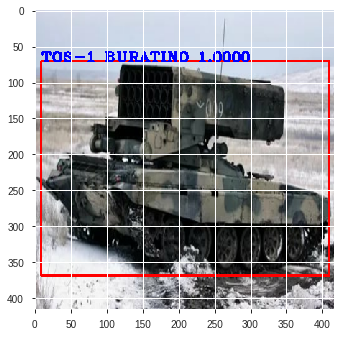

In [43]:
for image, labels in test_ds.take(1):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    print("labels:")
    for i in range(nums[0]):
        print(
            "\t{}, {}, {}".format(
                class_names[int(classes[0][i])],
                np.array(scores[0][i]),
                np.array(boxes[0][i]),
            )
        )

        img = draw_bbx(image.numpy(), (boxes, scores, classes, nums), class_names)
        plt.imshow(img.astype(int))